# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla GD, batch SGD and minibatch SGD. For this we consider a linear model with only two weights (the slope and the offset).

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn.parameter import Parameter
from tqdm.notebook import trange, tqdm

from line_regression import get_line_data, plot_regression, DynamicRegressionPlot

In [2]:
torch.__version__

'1.10.0+cu111'

## Dataset
Let's create the dataset. We generate a random vector $x \in [-0.5, 0.5]$ and evaluate it in a linear function $y = 2x$. We add some noise to $y$ and that give us $y \in [-1.5, 1.5]$.

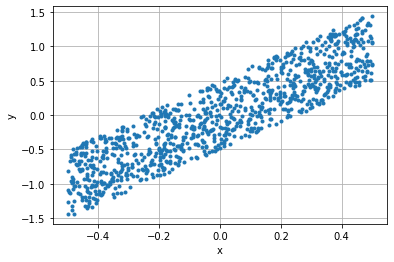

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
x_train, y_train, ground_truth = get_line_data(nsamples)

plt.plot(x_train, y_train, '.')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

## Input pipeline

In [4]:
# CPU/GPU Tensors
device = 'cpu' #'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)

In [5]:
# Initialize with random normal distribution
slope = Parameter(torch.randn([1], device=device))
offset = Parameter(torch.randn([1], device=device))
parameters = [slope, offset]

parameters

[Parameter containing:
 tensor([-1.3611], requires_grad=True),
 Parameter containing:
 tensor([0.4622], requires_grad=True)]

In [6]:
y_hat = slope*x + offset
error = (y_hat - y)**2
mse = error.mean()

print(mse)

tensor(1.2511, grad_fn=<MeanBackward0>)


In [7]:
mse.backward()

print([p.grad.item() for p in parameters])

[-0.5692841410636902, 0.9417179226875305]


  0%|          | 0/100 [00:00<?, ?it/s]

[1.8387688398361206, 0.01589248888194561]


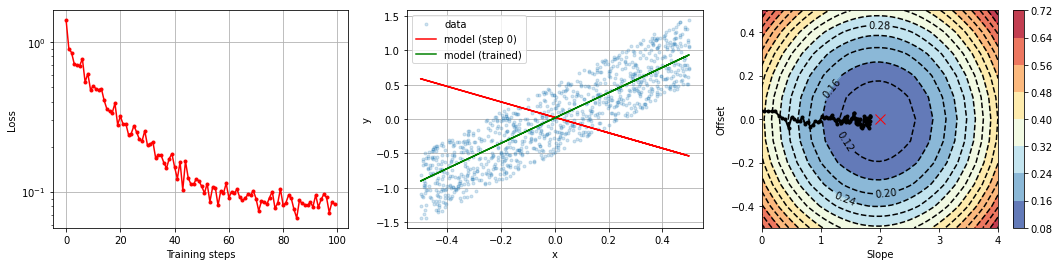

In [8]:
iters = 100
history = []
batch_size = 100
lr = 0.02 * batch_size**0.5
plot = DynamicRegressionPlot(ground_truth, display_every=10)

for i in trange(iters):
    # Sample batch
    batch = torch.randint(len(y), [batch_size])
    
    # Calculate loss
    y_hat = slope*x[batch] + offset
    error = (y_hat - y[batch])**2
    mse = error.mean()
    
    # Calculate gradients
    mse.backward()

    # Training step
    with torch.no_grad():
        for p in parameters:
            # SGD step
            p -= lr*p.grad
            # Clear gradients
            p.grad = None
        history.append([slope.item(), offset.item(), mse.item()])
#         plot.update_graph(history, x_train, y_train)
        
plot_regression(history, x_train, y_train, ground_truth)
print([p.item() for p in parameters])

<br><br><br><br><br><br><br><br><br><br>

<mark>Exercise</mark>: Try different batch sizes:
 * `batch_size = 1000` (The whole dataset)
 * `batch_size = 100` (Something between 1 and the size of whole dataset.)
 * `batch_size = 1`

1. Check the SGD trajectories. Why are they different?
2. The case `batch_size = 1` is quite slow compared to `batch_size = 100` and `batch_size = 1000`. Why?